# Rossmann Stores Sales Analysis and prediction


Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. In this Notebook we have carefully analysed different data's based on the factors like holidays, days of week etc as mentioned above.

The dataset used in this Analysis has been taken from Kaggle
: https://www.kaggle.com/c/rossmann-store-sales/data.

# Step 1: Loading the data

We are provided with historical sales data for 1,115 Rossmann stores. Our  task is to forecast the "Sales" column for the test set.
we have the following files which we will use in our forecast


#### train.csv - historical data including Sales


#### test.csv - historical data excluding Sales


#### sample_submission.csv - a sample submission file in the correct format


#### store.csv - Additional information about the stores.

# Data Fields

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what we have to  predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends.
a = public holiday,
b = Easter holiday, 
c = Christmas, 
0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval-describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

##### Importing the libraries 

In [1]:
#For Ignoring Warning
import warnings
warnings.filterwarnings("ignore")

## Handle table-like data and matrices
import numpy as np
import pandas as pd
import math

#visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

#modelling our algorithm
import sklearn


##### importing Our dataset 

In [2]:
store=pd.read_csv("store.csv")
train=pd.read_csv("train.csv",parse_dates = True, index_col = 'Date')

Tabular sample representation of store dataset of first and last 5 rows 

In [3]:
store.head().append(store.tail())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


Tabular sample representation of store dataset of first and last 5 rows

In [4]:
train.head().append(train.tail())

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


# Step 2- Handling Data Description

### Dealing with missing Values

In [5]:
#Count sum of missing values in store dataset
print("Store Dataset:\n\n",store.isnull().sum())

Store Dataset:

 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [6]:
#Count missing values in train dataset
print("Train Dataset:\n\n",train.isnull().sum())

Train Dataset:

 Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


In [7]:
#we can see that some features have a high percentage of missing values and they won't be accurate as indicators, 
#so we will remove features with more than 30% missing values.
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek',
                     'Promo2SinceYear', 'PromoInterval'], axis=1)

 Visualising the Distribution of data

Text(0.5, 1.0, 'Distributin of Store Competition Distance')

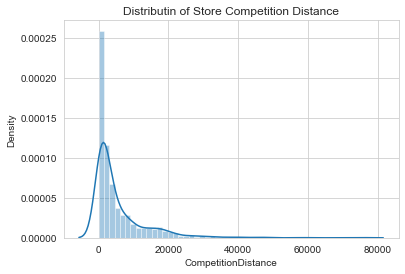

In [8]:
# CompetitionDistance is distance in meters to the nearest competitor store
# let's first have a look at its distribution
sns.distplot(store.CompetitionDistance.dropna())
plt.title("Distributin of Store Competition Distance")

As we can see from the following graph plot that the distribution has its tail on the right side, so 
it is a Right Skewed Distribution.
so we'll replace missing values with the median.

In [9]:
# replace missing values in CompetitionDistance with median for the store dataset
store.CompetitionDistance.fillna(store.CompetitionDistance.median(), inplace=True)

### Extracting the Days, Month, day and week of year from "Date" 

In [10]:
train["Year"]=train.index.year
train["Month"]=train.index.month
train["Day"]=train.index.day
train["WeekOfYear"]=train.index.week
train = train.reset_index()

In [11]:
train

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31
1,2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31
2,2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31
3,2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31
4,2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,2013-01-01,1111,2,0,0,0,0,a,1,2013,1,1,1
1017205,2013-01-01,1112,2,0,0,0,0,a,1,2013,1,1,1
1017206,2013-01-01,1113,2,0,0,0,0,a,1,2013,1,1,1
1017207,2013-01-01,1114,2,0,0,0,0,a,1,2013,1,1,1


### Merging The tables

In [12]:
df = pd.merge(train, store, how='left', on='Store')
df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2
0,2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,c,a,1270.0,0
1,2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,a,a,570.0,1
2,2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,a,a,14130.0,1
3,2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,c,c,620.0,0
4,2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,a,a,29910.0,0


In [13]:
len(df)

1017209

### Drop subsets of data which might cause Bias

Bias- it is the simplifying assumptions made by the model to make the target function easier to approximate and thus make the end prediction biased. 

In [14]:
# where stores are closed, they won't generate sales, so we will remove this part of the dataset
df = df[df.Open != 0]

In [15]:
# Open isn't a variable anymore, so we'll drop it
df = df.drop('Open', axis=1)

In [16]:
# see if there's any opened store with zero sales
print("Number of stores with zero sales:",df[df.Sales == 0].shape[0])

Number of stores with zero sales: 54


In [17]:
# remove this part of data to avoid bias
df = df[df.Sales != 0]

In [18]:
df.head()

,Date,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2
0,2015-07-31,1,5,5263,555,1,0,1,2015,7,31,31,c,a,1270.0,0
1,2015-07-31,2,5,6064,625,1,0,1,2015,7,31,31,a,a,570.0,1
2,2015-07-31,3,5,8314,821,1,0,1,2015,7,31,31,a,a,14130.0,1
3,2015-07-31,4,5,13995,1498,1,0,1,2015,7,31,31,c,c,620.0,0
4,2015-07-31,5,5,4822,559,1,0,1,2015,7,31,31,a,a,29910.0,0


### Handling Categorical Data

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Date                 844338 non-null  datetime64[ns]
 1   Store                844338 non-null  int64         
 2   DayOfWeek            844338 non-null  int64         
 3   Sales                844338 non-null  int64         
 4   Customers            844338 non-null  int64         
 5   Promo                844338 non-null  int64         
 6   StateHoliday         844338 non-null  object        
 7   SchoolHoliday        844338 non-null  int64         
 8   Year                 844338 non-null  int64         
 9   Month                844338 non-null  int64         
 10  Day                  844338 non-null  int64         
 11  WeekOfYear           844338 non-null  int64         
 12  StoreType            844338 non-null  object        
 13  Assortment   

In [20]:
# see what's in nominal varibles 
set(df.StateHoliday), set(df.StoreType), set(df.Assortment)

({'0', 0, 'a', 'b', 'c'}, {'a', 'b', 'c', 'd'}, {'a', 'b', 'c'})

# StateHoliday indicates a state holiday  where 
#### a = public holiday,
#### b = Easter holiday,
#### c = Christmas,
#### 0 = None
### convert number 0 to string 0


In [21]:
df.loc[df.StateHoliday == 0,'StateHoliday'] = df.loc[df.StateHoliday == 0,'StateHoliday'].astype(str)

In [22]:
set(df.StateHoliday)

{'0', 'a', 'b', 'c'}

In [23]:
# 0 - not a state holiday; 1- is on a state holiday
df['StateHoliday'] = df.StateHoliday.map({'0':0, 'a':1 ,'b' : 1,'c': 1})

In [24]:
set(df.StateHoliday)

{0, 1}

# Step-3: Adding Additional Features

In [25]:
#Making a Copy of the existing dataset
df1 = df.copy()

In [26]:
# calculate weekly average sales
sales = df1[['Year','Month','Store','Sales']].groupby(['Year','Month','Store']).mean()
sales = sales.rename(columns={'Sales':'AvgSales'})
sales = sales.reset_index()

In [27]:
sales.head()

,Year,Month,Store,AvgSales
0,2013,1,1,4939.653846
1,2013,1,2,4429.653846
2,2013,1,3,6371.269231
3,2013,1,4,9027.423077
4,2013,1,5,4209.307692


In [28]:
df1['sales_key']=df1['Year'].map(str) + df1['Month'].map(str) + df1['Store'].map(str)
sales['sales_key']=sales['Year'].map(str) + sales['Month'].map(str) + sales['Store'].map(str)

In [29]:
# drop extra columns
sales = sales.drop(['Year','Month','Store'], axis=1)
# merge
df1 = pd.merge(df1, sales, how='left', on=('sales_key'))

In [30]:
#create a variable that calculates Monthly average number of customers for each store.
cust = df1[['Year','Month','Store','Customers']].groupby(['Year','Month', 'Store']).mean()
cust = cust.rename(columns={'Customers':'AvgCustomer'})
cust = cust.reset_index()

In [31]:
df1['cust_key']=df1['Year'].map(str) + df1['Month'].map(str) + df1['Store'].map(str)
cust['cust_key']=cust['Year'].map(str) + cust['Month'].map(str) + cust['Store'].map(str)

In [32]:
# drop original feature Customers
df1 = df1.drop('Customers', axis=1)

In [33]:
# drop extra columns
cust = cust.drop(['Year', 'Month', 'Store'], axis=1)

In [34]:
# merge
df1 = pd.merge(df1, cust, how="left", on=('cust_key'))

In [35]:
# drop extra columns
df1 = df1.drop(['cust_key','sales_key','Store','Date'], axis=1)

In [36]:
df1.head()

,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,Promo2,AvgSales,AvgCustomer
0,5,5263,1,0,1,2015,7,31,31,c,a,1270.0,0,4491.333333,519.407407
1,5,6064,1,0,1,2015,7,31,31,a,a,570.0,1,4954.259259,621.222222
2,5,8314,1,0,1,2015,7,31,31,a,a,14130.0,1,6797.592593,682.888889
3,5,13995,1,0,1,2015,7,31,31,c,c,620.0,0,10256.851852,1294.259259
4,5,4822,1,0,1,2015,7,31,31,a,a,29910.0,0,4599.629630,521.703704


# Step-4: Exploratory Data Analysis

In [37]:
dfv = df.copy()

In [38]:
{"Mean":np.mean(dfv.Sales),"Median":np.median(dfv.Sales)}

{'Mean': 6955.959133664481, 'Median': 6369.0}

## Sales Distribution

Text(0.5, 1.0, 'Sales Distribution')

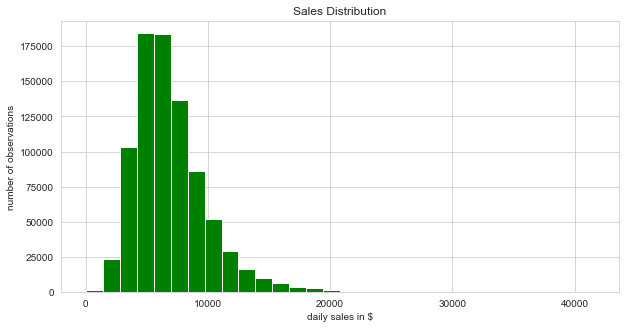

In [39]:
plt.figure(figsize=(10,5))
plt.hist(x=dfv.Sales, bins=30,color = "green")
plt.ylabel('number of observations')
plt.xlabel('daily sales in $')
plt.title('Sales Distribution')

The amount in $  on daily basis based on sales and no of observations made

### Customer Distribution 

In [40]:
{"Mean":np.mean(dfv.Customers),"Median":np.median(dfv.Customers)}

{'Mean': 762.777166253325, 'Median': 676.0}

Text(0.5, 1.0, 'Customer Distribution')

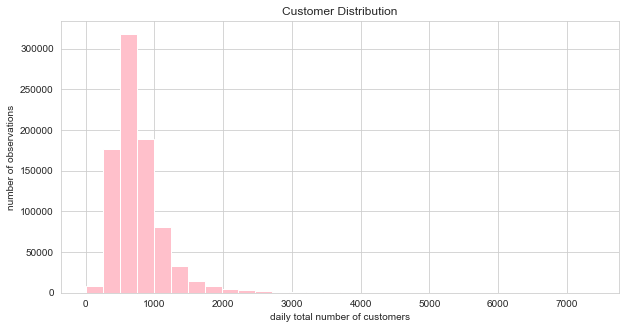

In [41]:
plt.figure(figsize=(10,5))
plt.hist(x=dfv.Customers , bins=30,color = "pink")
plt.ylabel('number of observations')
plt.xlabel('daily total number of customers')
plt.title('Customer Distribution')

The average daily no of customer based on observation

### Sales over a time

In [42]:
store1_2015 = dfv.query('Store == 1 and Year == 2015')
store1_2013 = dfv.query('Store == 1 and Year == 2013')
store1_2014 = dfv.query('Store == 1 and Year == 2014')

Text(0.5, 1.0, 'Sales Over Time')

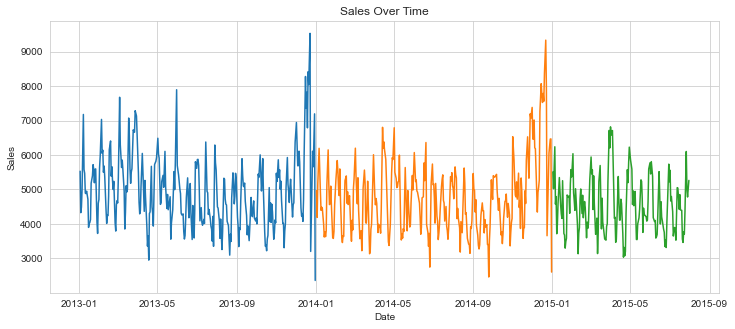

In [43]:
plt.figure(figsize=(12,5))
sns.lineplot(x=store1_2013.Date, y=store1_2013.Sales, data=store1_2013)
sns.lineplot(x=store1_2014.Date, y=store1_2014.Sales, data=store1_2014)
sns.lineplot(x=store1_2015.Date, y=store1_2015.Sales, data=store1_2015)
plt.title('Sales Over Time')

The average of the sales over a time period is given in the figure
We cas see that the sales are at its peak near every new year i.e around the time of christmas

### Sales over week 

Text(0.5, 1.0, 'Sales Over Weeks')

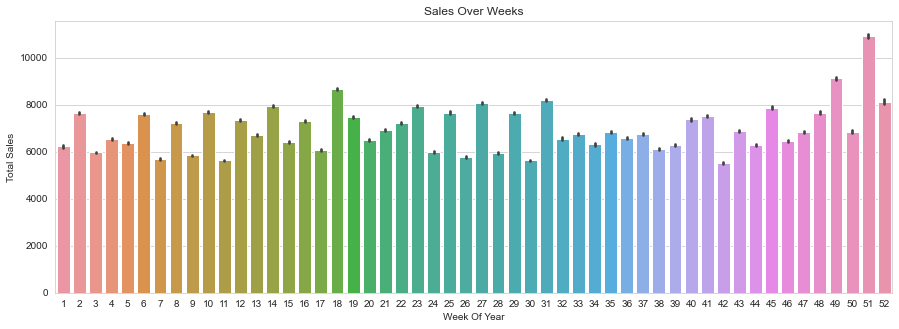

In [44]:
plt.figure(figsize=(15,5))
sns.barplot(x=dfv['WeekOfYear'],y=dfv['Sales'],data=dfv)
plt.xlabel('Week Of Year')
plt.ylabel('Total Sales')
plt.title('Sales Over Weeks')

### Sales by store type

Text(0.5, 1.0, 'Sales By Store Type')

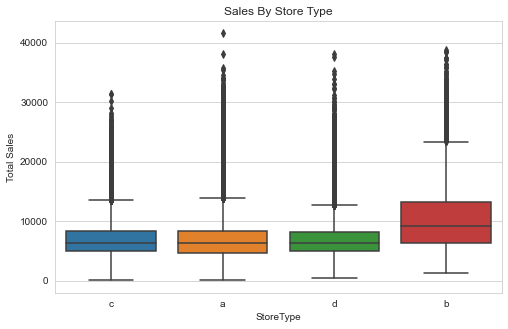

In [45]:
# StoreType - differentiates between 4 different store models: a, b, c, d
plt.figure(figsize=(8,5))
sns.boxplot(x=dfv.StoreType, y=dfv.Sales, data=dfv)
plt.ylabel('Total Sales')
plt.title('Sales By Store Type')

### Sales by Assortment

Text(0.5, 1.0, 'Sales By Assortment')

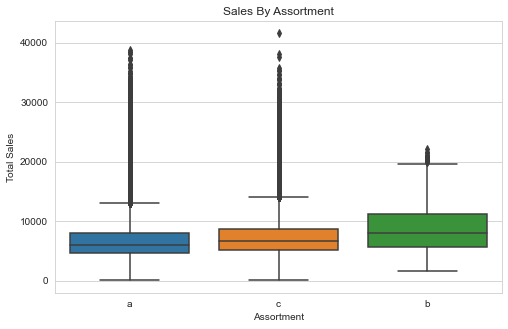

In [46]:
plt.figure(figsize=(8,5)) 
sns.boxplot(x=dfv.Assortment, y=dfv.Sales, data=dfv) 
plt.ylabel('Total Sales') 
plt.title('Sales By Assortment')

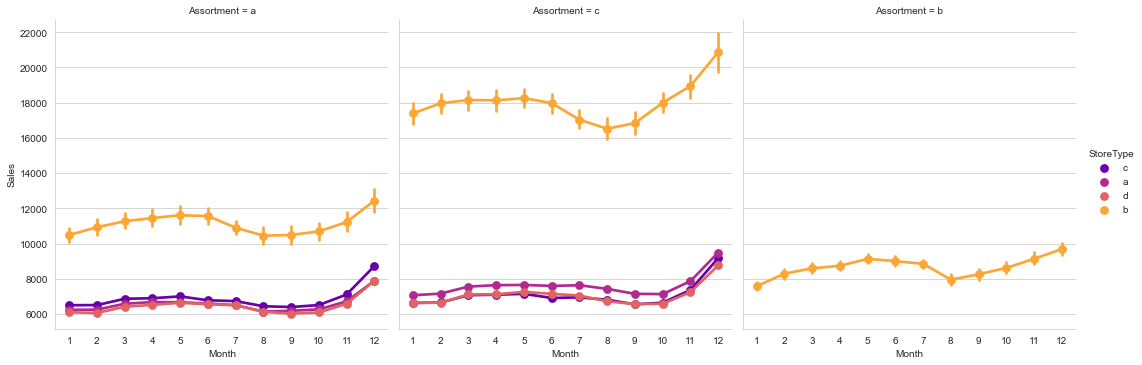

In [47]:
sns.factorplot(data = dfv, x = 'Month', y = "Sales", 
               col = 'Assortment',
               palette = 'plasma',
               hue = 'StoreType')

### Sales vs. Competition Distance

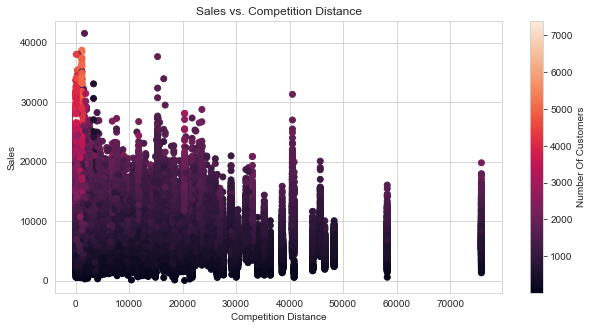

In [48]:
plt.figure(figsize=(10,5))
plt.scatter(x=dfv.CompetitionDistance, y=dfv.Sales , c=dfv.Customers)
plt.ylabel('Sales')
plt.xlabel('Competition Distance')
plt.title('Sales vs. Competition Distance')
cbr= plt.colorbar()
cbr.set_label('Number Of Customers')

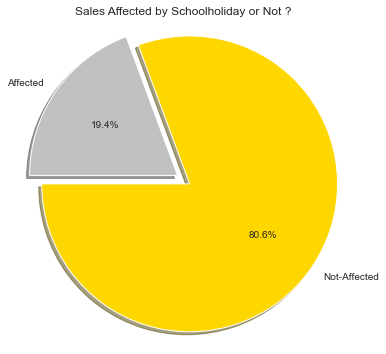

In [49]:
labels = 'Not-Affected' , 'Affected'
sizes = df.SchoolHoliday.value_counts()
colors = ['gold', 'silver']
explode = (0.1, 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Sales Affected by Schoolholiday or Not ?")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

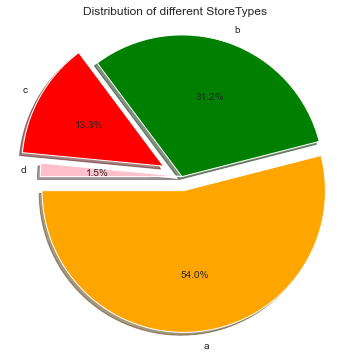

In [50]:
labels = 'a' , 'b' , 'c' , 'd'
sizes = store.StoreType.value_counts()
colors = ['orange', 'green' , 'red' , 'pink']
explode = (0.1, 0.0 , 0.15 , 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Distribution of different StoreTypes")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

<AxesSubplot:xlabel='Assortment', ylabel='count'>

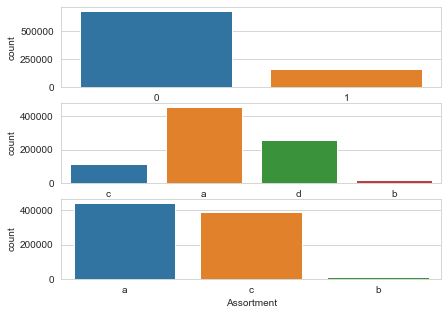

In [51]:
plt.figure(figsize=(15,5))
a = dfv[dfv['SchoolHoliday'] != 'regular_day']
plt.subplot(3,2,1)
sns.countplot(a['SchoolHoliday'])

sns.kdeplot(dfv[dfv['SchoolHoliday'] == 'public_holiday']['Sales'],label = 'public_holiday',shade = True)
sns.kdeplot(dfv[dfv['SchoolHoliday'] == 'easter_holiday']['Sales'],label = 'easter_holiday',shade = True)
sns.kdeplot(dfv[dfv['SchoolHoliday'] == 'christmas']['Sales'],label = 'christmas',shade = True)

#store_type

plt.subplot(3,2,3)
sns.countplot(dfv['StoreType'])

#assortment
plt.subplot(3,2,5)
sns.countplot(dfv['Assortment'])


From all the plots above, we can get some conclusions:

state_holiday -> We have a much larger amount of sales on public holidays, but at Christmas, which has a smaller amount of sales than easter_holiday, it has a higher peak.

store_type -> The store_type "a" that sells more, does not have such a peak compared to the others.

assortment -> We see that stores with the "extra" type assortment sell less, but have a higher distribution. So, there are stores that sell more with the "extra" assortment and stores that sell less.

### Impact of promotion on sales over days of a week

In [52]:
print ("Number of Stores opened on Sundays:{}" .format(dfv[dfv.DayOfWeek == 7]['Store'].unique().shape[0]))

Number of Stores opened on Sundays:33


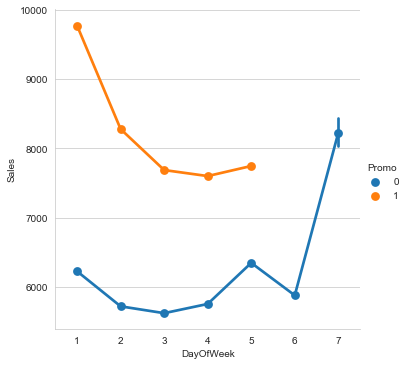

In [53]:
sns.factorplot(data = dfv, x ="DayOfWeek", y = "Sales",
                hue='Promo'
               
              ,sharex=False)

## Corelation Heatmap

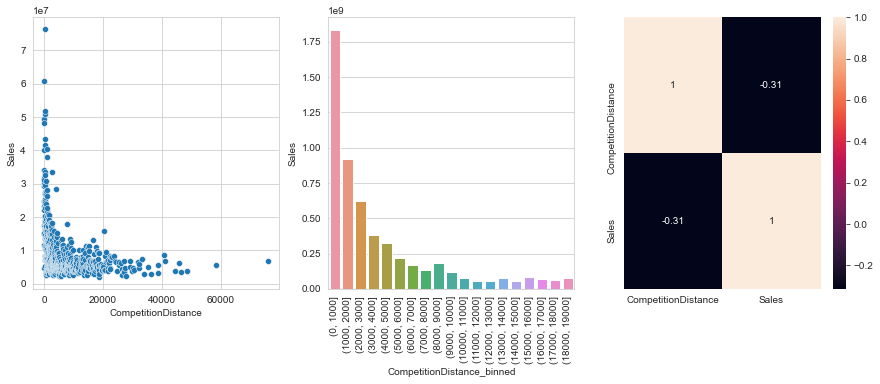

In [54]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
aux1 = dfv[['CompetitionDistance','Sales']].groupby('CompetitionDistance').sum().reset_index()
sns.scatterplot(x = 'CompetitionDistance', y = 'Sales', data = aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['CompetitionDistance_binned'] = pd.cut(aux1['CompetitionDistance'], bins = bins)
aux2 = aux1[['CompetitionDistance_binned','Sales']].groupby('CompetitionDistance_binned').sum().reset_index()
sns.barplot(x = 'CompetitionDistance_binned', y = 'Sales', data = aux2);
plt.xticks(rotation = 90)
    
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

## from above figure we conclude that 
### Stores with longer competitors sell less.

## sale of store after the 10th of each month

<AxesSubplot:xlabel='before_after', ylabel='Sales'>

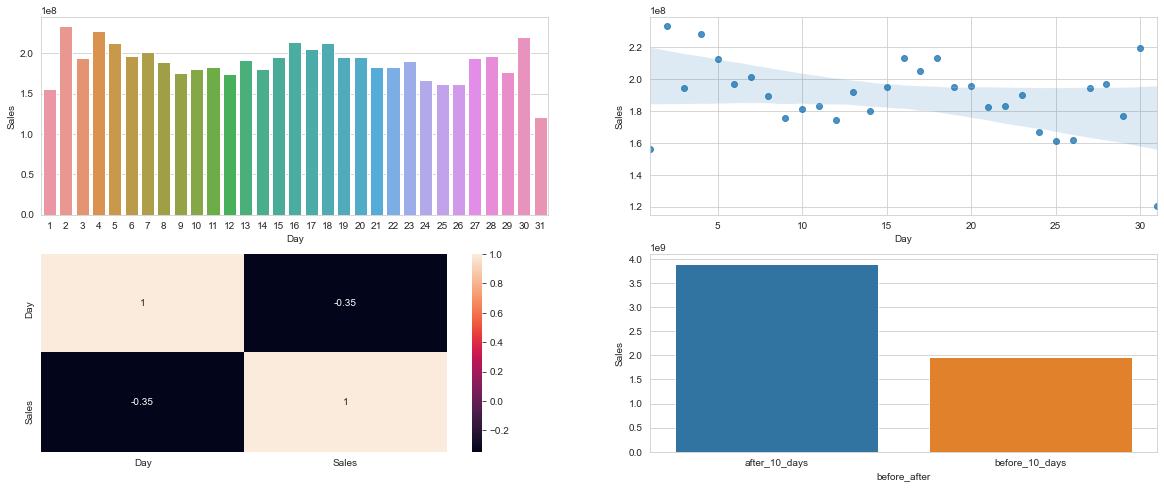

In [55]:
plt.figure(figsize=(20,8))
aux1 = dfv[['Day','Sales']].groupby('Day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'Day',y = 'Sales', data = aux1)

plt.subplot(2,2,2)
sns.regplot(x = 'Day',y = 'Sales', data = aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

plt.subplot(2,2,4)
aux1['before_after'] = aux1['Day'].apply(lambda x:'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','Sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'Sales', data = aux2)

#### Stores sell more after the 10th of each month.

## Sale of store in the second half of the year

<AxesSubplot:>

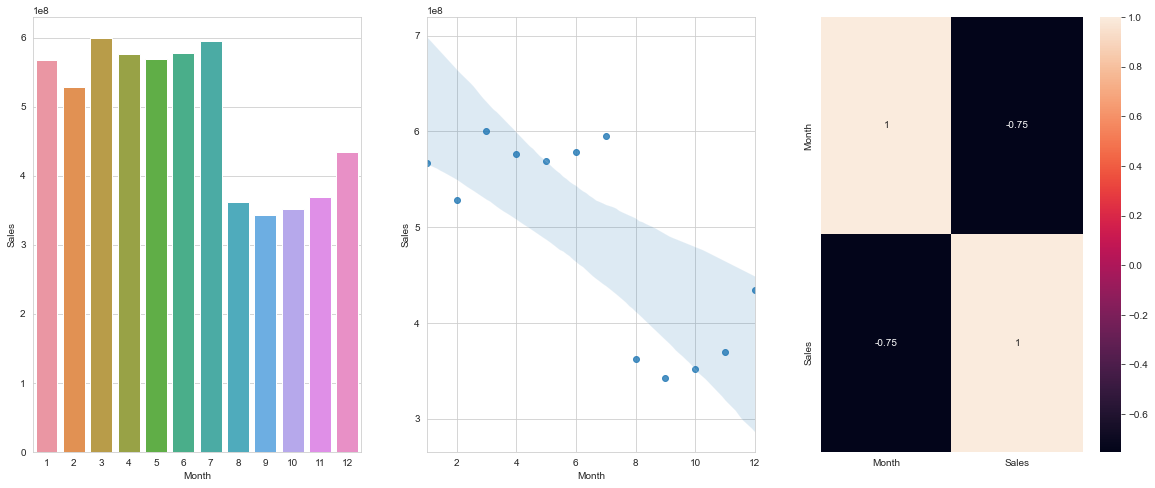

In [56]:
plt.figure(figsize=(20,8))
aux1 = dfv[['Month','Sales']].groupby('Month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'Month',y = 'Sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'Month',y = 'Sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### Sale of store is less in 2nd half of the year

## Sale of Store over the Year

<AxesSubplot:>

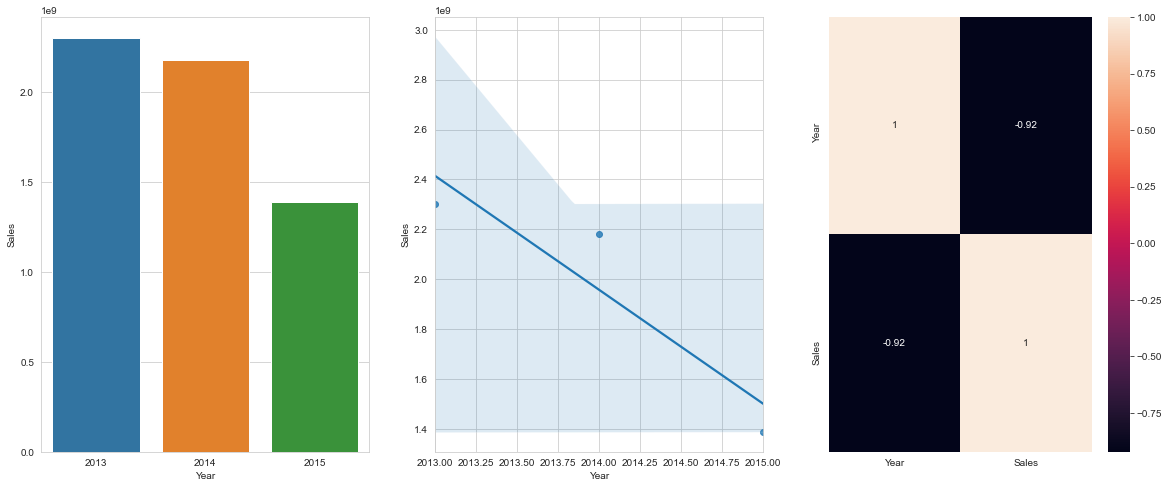

In [57]:
plt.figure(figsize=(20,8))
aux1 = dfv[['Year','Sales']].groupby('Year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'Year',y = 'Sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'Year',y = 'Sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

## Sale of Store has decreased over the year

## Sale of Store over the Weekends 

<AxesSubplot:>

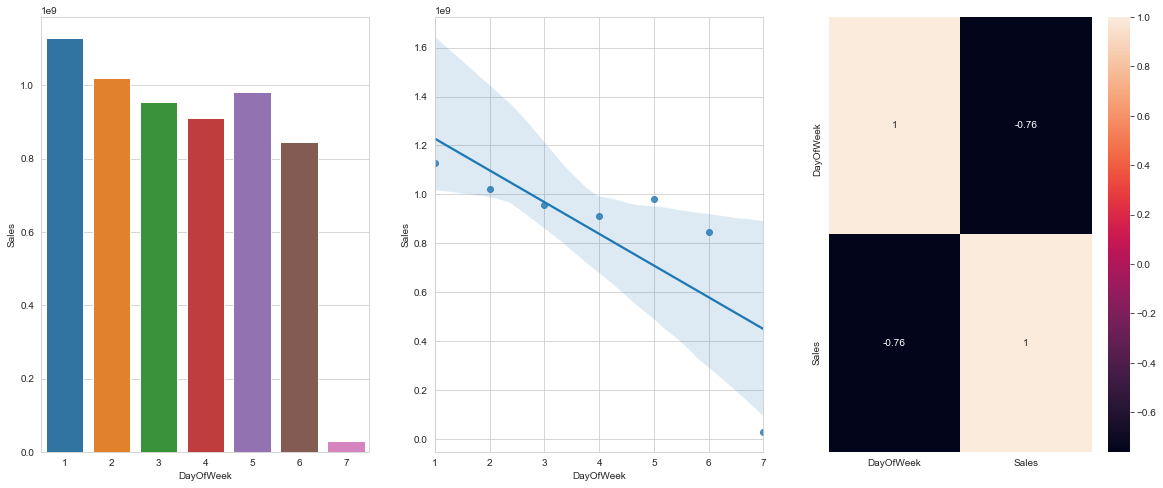

In [58]:
plt.figure(figsize=(20,8))
aux1 = dfv[['DayOfWeek','Sales']].groupby('DayOfWeek').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'DayOfWeek',y = 'Sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'DayOfWeek',y = 'Sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

### Stores sell less on weekends.

## Sale during School Holiday

<AxesSubplot:xlabel='Month', ylabel='Sales'>

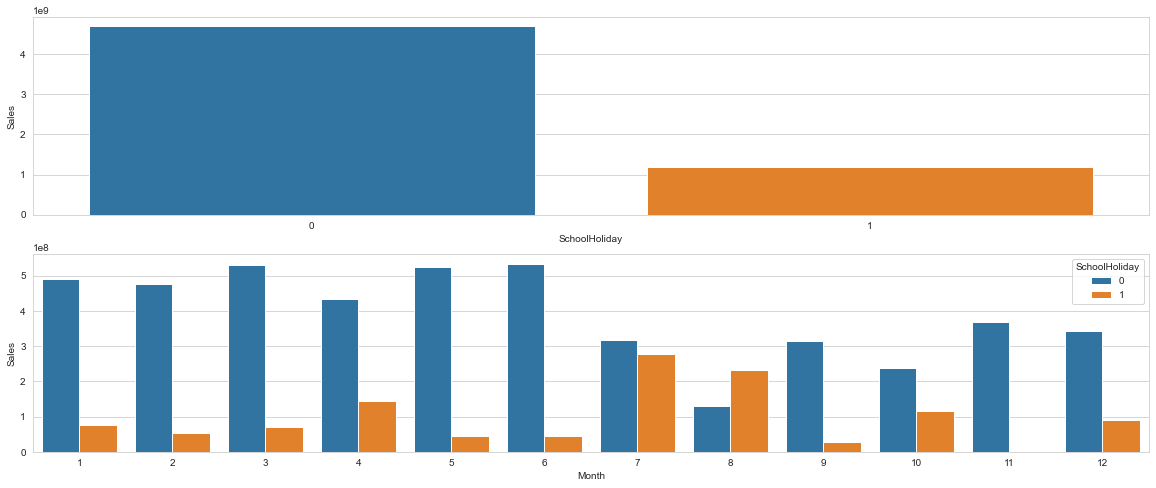

In [59]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
aux1 = dfv[['SchoolHoliday','Sales']].groupby('SchoolHoliday').sum().reset_index()
sns.barplot(x = 'SchoolHoliday',y = 'Sales', data = aux1)

plt.subplot(2,1,2)
aux2 = dfv[['Month','SchoolHoliday','Sales']].groupby(['Month','SchoolHoliday']).sum().reset_index()
sns.barplot(x = 'Month',y = 'Sales',hue = 'SchoolHoliday', data = aux2)

### Stores sell less during school holidays except in July and August.

# Final Correalation HeatMap

In [60]:
# Converting categorial features Assortment and StoreType  
dfv['Assortment']=dfv['Assortment'].astype('category').cat.codes
dfv['StoreType']=dfv['StoreType'].astype('category').cat.codes

# Adding new feature SalesperCustomer to get better correlation with StoreType and Assortment
dfv['SalesperCustomer']=dfv['Sales']/dfv['Customers']
corr = dfv.corr()

Text(0.5, 1.0, 'Correlation Heatmap')

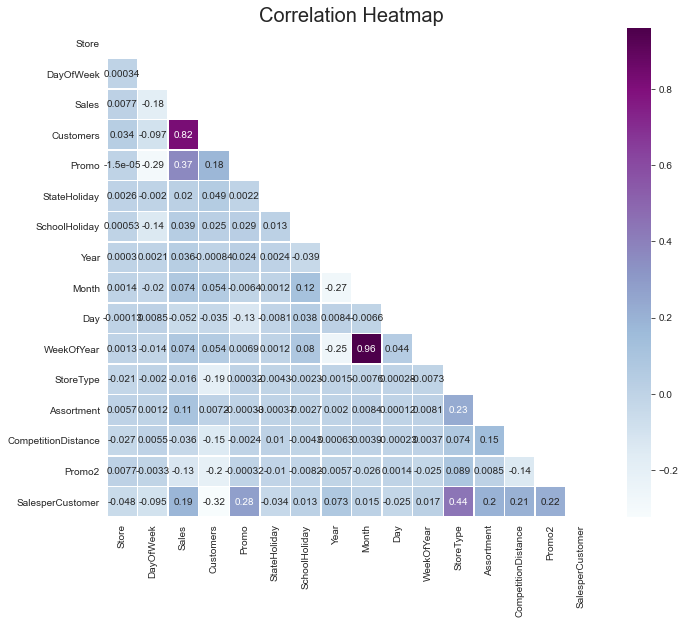

In [61]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (11, 9))
sns.heatmap(corr, mask = mask, annot= True,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")
plt.title("Correlation Heatmap", fontsize=20)

# Step-5: Machine Learning Data Modelling

In [62]:
# split features and labels
X = df1.drop('Sales', axis=1)
y = df1.Sales

In [63]:
# get dummy variables for categorical features for linear regression
xd = X.copy()
xd = pd.get_dummies(xd)

In [64]:
xd.head()

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,CompetitionDistance,Promo2,AvgSales,AvgCustomer,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,5,1,0,1,2015,7,31,31,1270.0,0,4491.333333,519.407407,0,0,1,0,1,0,0
1,5,1,0,1,2015,7,31,31,570.0,1,4954.259259,621.222222,1,0,0,0,1,0,0
2,5,1,0,1,2015,7,31,31,14130.0,1,6797.592593,682.888889,1,0,0,0,1,0,0
3,5,1,0,1,2015,7,31,31,620.0,0,10256.851852,1294.259259,0,0,1,0,0,0,1
4,5,1,0,1,2015,7,31,31,29910.0,0,4599.629630,521.703704,1,0,0,0,1,0,0


In [65]:
# split training and test datasets
from sklearn.model_selection import train_test_split
xd_train,xd_test,yd_train,yd_test = train_test_split(xd,y,test_size=0.3, random_state=1)

In [68]:
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Linear Regression

In [69]:
lin= LinearRegression()
linreg = lin.fit(xd_train, yd_train)

In [70]:
# definte RMSE function
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(x, y):
    return sqrt(mean_squared_error(x, y))

# definte MAPE function
def mape(x, y): 
    return np.mean(np.abs((x - y) / x)) * 100 

# get cross validation scores 
yd_predicted = linreg.predict(xd_train)
yd_test_predicted = linreg.predict(xd_test)

print("Regresion Model Score" , ":" , linreg.score(xd_train, yd_train) , "," ,
      "Out of Sample Test Score" ,":" , linreg.score(xd_test, yd_test))
print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training MAPE", ":", mape(yd_train, yd_predicted),
      "Testing MAPE", ":", mape(yd_test, yd_test_predicted))

regression_train = linreg.score(xd_train, yd_train)
regression_test = linreg.score(xd_test, yd_test)

Regresion Model Score : 0.7486872962950806 , Out of Sample Test Score : 0.748288427394808
Training RMSE : 1552.8927784361238 Testing RMSE : 1556.032725703269
Training MAPE : 16.996208120525772 Testing MAPE : 17.053657649225006


# KNN (k-nearest-neighbour)

In [71]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors = 30)
knnreg = knn.fit(xd_train, yd_train)

In [72]:
print("Regresion Model Score" , ":" , knnreg.score(xd_train, yd_train) , "," ,
      "Out of Sample Test Score" ,":" , knnreg.score(xd_test, yd_test))

yd_predicted = knnreg.predict(xd_train)
yd_test_predicted = knnreg.predict(xd_test)

print("Training RMSE", ":", rmse(yd_train, yd_predicted),
      "Testing RMSE", ":", rmse(yd_test, yd_test_predicted))
print("Training MAPE", ":", mape(yd_train, yd_predicted),
      "Testing MAPE", ":", mape(yd_test, yd_test_predicted))

Knn_train = knnreg.score(xd_train, yd_train)
Knn_test =  knnreg.score(xd_test, yd_test)

Regresion Model Score : 0.6514919969772337 , Out of Sample Test Score : 0.6277013414400041
Training RMSE : 1828.6922605326138 Testing RMSE : 1892.399701290796
Training MAPE : 21.983167017591406 Testing MAPE : 22.787960576353292


In [73]:
for x in range(1,30):
    knn = KNeighborsRegressor(n_neighbors = x)
    knnreg = knn.fit(xd_train, yd_train)
    print("Regresion Model Score" , ":" , knnreg.score(xd_train, yd_train) , "," ,
      "Out of Sample Test Score" ,":" , knnreg.score(xd_test, yd_test))

Regresion Model Score : 1.0 , Out of Sample Test Score : 0.6713355460740096
Regresion Model Score : 0.9174382077256099 , Out of Sample Test Score : 0.7028982767164882
Regresion Model Score : 0.8674079040730915 , Out of Sample Test Score : 0.6882273118515285
Regresion Model Score : 0.8237553183676828 , Out of Sample Test Score : 0.6622603886847955
Regresion Model Score : 0.7831555142797049 , Out of Sample Test Score : 0.6380455436468406
Regresion Model Score : 0.7479327384709074 , Out of Sample Test Score : 0.6209075764677412
Regresion Model Score : 0.7207553684123154 , Out of Sample Test Score : 0.609514759500425
Regresion Model Score : 0.7003407202710207 , Out of Sample Test Score : 0.6021167949934485
Regresion Model Score : 0.684490153400208 , Out of Sample Test Score : 0.5973257493711543
Regresion Model Score : 0.6729819312035159 , Out of Sample Test Score : 0.5957241805089737
Regresion Model Score : 0.6653044886979489 , Out of Sample Test Score : 0.5970751625091903
Regresion Model 

# Desicion Tree Model

In [79]:
#Build decision tree model
tree_model = DecisionTreeRegressor(min_samples_leaf=20)

#Train model on training dataset
dt= tree_model.fit(xd_train, yd_train)
print(dt)


DecisionTreeRegressor(min_samples_leaf=20)


In [80]:
#Predict using model

yd_pred = tree_model.predict(xd_train)


#Calculate RMSE and MAPE

print("The model performance for training dataset:\n")
print("RMSE :",rmse(yd_train, yd_pred))
print("MAPE :",mape(yd_train, yd_pred))

The model performance for training dataset:

RMSE : 965.1957518847966
MAPE : 9.790382120656403


In [81]:
dtree_train = dt.score(xd_train, yd_train)
dtree_test =  dt.score(xd_test, yd_test)

# Comparision between the model

In [84]:

import pandas as pd

train_error=[regression_train,dtree_train,Knn_train]

test_error=[regression_test,dtree_test,Knn_test]

col={'Train Error':train_error,'Test Error':test_error}
models=['Linear Regression','Dtree','Knn']
dfm=pd.DataFrame(data=col,index=models)
dfm

,Train Error,Test Error
Linear Regression,0.748687,0.748288
Dtree,0.902913,0.874704
Knn,0.651492,0.627701


<AxesSubplot:>

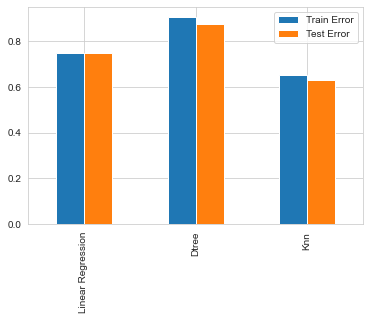

In [85]:
#PLotting the table into a graph using Bar Plot
dfm.plot(kind='bar')

# Feature Importance

In [87]:
features = xd_train.columns
importances = dt.feature_importances_
indices = np.argsort(importances)

Text(0.5, 0, 'Relative Importance')

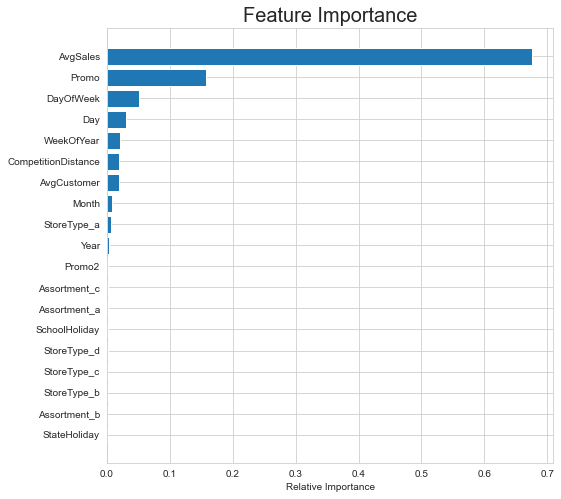

In [88]:
plt.figure(figsize=(8,8))
plt.title('Feature Importance', fontsize=20)
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

# Average Sales has the most impact on the model